# SMAD2

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SMAD2'
mane_tx_id = 'NM_005901.6'
mane_protein_id = 'NP_005892.1' # mothers against decapentaplegic homolog 2 isoform 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = gene_symbol

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 23/23 [00:00<00:00, 94.72 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
10,Thoracic aortic aneurysm
7,Scoliosis
7,Arthralgia
7,High palate
6,Arachnodactyly
5,Atrial septal defect
5,Double outlet right ventricle
5,Inguinal hernia
5,Bruising susceptibility
5,Tall stature


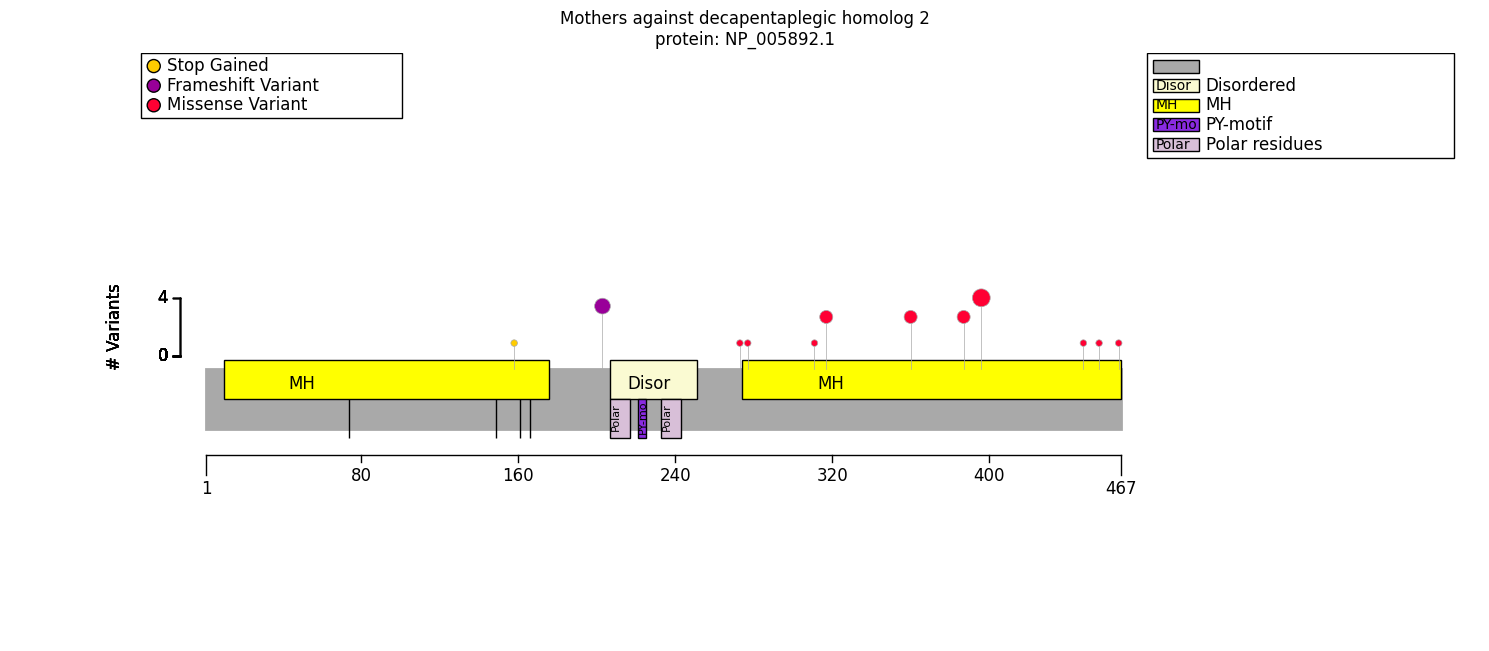

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

smad2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
smad2_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis
We were not able to identify published results suggesting correlations with specific SMAD2 residues or variant categories.

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer



ser397tyr = variant_key("18_47845430_47845430_G_T") #c.1190C>A	p.Ser397Tyr
ser397tyr_clf = monoallelic_classifier(
    a_predicate=ser397tyr,
    b_predicate=~ser397tyr,
    a_label="Ser397Tyr",
    b_label="Other"
)
ser397tyr_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ser397tyr_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(ser397tyr_result)

Reason,Count
Skipping term because one genotype had zero observations,1
"Skipping ""general"" level terms",70
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),198


In [8]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, ser397tyr_result)

Allele group,Ser397Tyr,Other,Corrected p values,p values
Hypertelorism [HP:0000316],3/4 (75%),1/10 (10%),0.735931,0.040959
Scoliosis [HP:0002650],0/4 (0%),7/10 (70%),0.735931,0.069930
Arachnodactyly [HP:0001166],0/4 (0%),6/10 (60%),0.735931,0.084915
Thoracic aortic aneurysm [HP:0012727],1/4 (25%),9/12 (75%),0.767857,0.118132
Inguinal hernia [HP:0000023],0/3 (0%),5/8 (62%),0.945455,0.181818
Abnormal sternum morphology [HP:0000766],0/4 (0%),5/11 (45%),1.000000,0.230769
Downslanted palpebral fissures [HP:0000494],0/4 (0%),2/6 (33%),1.000000,0.466667
Pes planus [HP:0001763],0/2 (0%),4/9 (44%),1.000000,0.490909
Broad uvula [HP:0010809],0/4 (0%),2/7 (29%),1.000000,0.490909
Carotid artery dissection [HP:0012158],0/4 (0%),2/7 (29%),1.000000,0.490909


In [9]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

nterm = protein_region(region=Region(1,350), tx_id=mane_tx_id)
nterm_clf = monoallelic_classifier(
    a_predicate=nterm,
    b_predicate=~nterm,
    a_label="N Term",
    b_label="Other"
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
     pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, nterm_result)


Allele group,N Term,Other,Corrected p values,p values
Arachnodactyly [HP:0001166],4/4 (100%),2/10 (20%),0.404595,0.014985
Thoracic aortic aneurysm [HP:0012727],5/5 (100%),5/11 (45%),0.981818,0.093407
Arthralgia [HP:0002829],0/2 (0%),7/9 (78%),0.981818,0.109091
Tall stature [HP:0000098],4/5 (80%),1/5 (20%),1.000000,0.206349
High palate [HP:0000218],4/7 (57%),3/11 (27%),1.000000,0.332202
Abdominal aortic aneurysm [HP:0005112],1/5 (20%),0/6 (0%),1.000000,0.454545
Scoliosis [HP:0002650],2/2 (100%),5/12 (42%),1.000000,0.461538
Pes planus [HP:0001763],0/2 (0%),4/9 (44%),1.000000,0.490909
Varicose veins [HP:0002619],0/2 (0%),4/10 (40%),1.000000,0.515152
Dolichocephaly [HP:0000268],2/5 (40%),1/6 (17%),1.000000,0.545455


In [10]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)


Sex,FEMALE,MALE,Corrected p values,p values
Scoliosis [HP:0002650],3/9 (33%),4/5 (80%),1.0,0.265734
Abnormal sternum morphology [HP:0000766],2/9 (22%),3/6 (50%),1.0,0.328671
Bifid uvula [HP:0000193],0/9 (0%),1/5 (20%),1.0,0.357143
Pectus excavatum [HP:0000767],0/7 (0%),1/4 (25%),1.0,0.363636
Carotid artery dissection [HP:0012158],1/8 (12%),1/3 (33%),1.0,0.490909
Dolichocephaly [HP:0000268],2/5 (40%),1/6 (17%),1.0,0.545455
Inguinal hernia [HP:0000023],3/8 (38%),2/3 (67%),1.0,0.545455
Pes planus [HP:0001763],2/7 (29%),2/4 (50%),1.0,0.575758
High palate [HP:0000218],6/13 (46%),1/5 (20%),1.0,0.595588
Thoracic aortic aneurysm [HP:0012727],5/9 (56%),5/7 (71%),1.0,0.632867


# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=ser397tyr_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "No significant correlations with specific SMAD2 residues or variant categories were identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Ser397Tyr,Other,26,0
Genotype (A),Genotype (B),Tests performed,Significant tests
N Term,Other,27,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,27,0


In [13]:
summarizer.process_latex(report=report, protein_fig=smad2_fig)

Figure saved to ../../supplement/img/SMAD2_protein_diagram-draft.pdf
Output to ../../supplement/tex/SMAD2_summary_draft.tex
